In [1]:
import cv2, os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
from shutil import copy2

In [2]:
cycle_gan_dir = 'pytorch-CycleGAN-and-pix2pix'
vangogh_dir = 'results/vangogh2photo/test_latest/images'
photos_dir = 'datasets/vangoghlandscape2photo/trainB'

os.chdir(cycle_gan_dir)

In [3]:
content_imgs = ['1200px-The_Farm_close.JPG.jpg',
                'photo.jpg',
                '_20211110_on_zimbabwebigtree-finally-gets-an-age.jpg',
                'amazing-mountain-landscape-colorful-vivid-260nw-693715240.jpg',
                'ComunityTrees-MK-580x370.jpg',
                '56883926_303.jpg',
                'crop-farmer.jpg',
                'Tree20Benefits20-2002.jpg',
                'old-run-down-farm-house-667761.jpg',
                '014bba38ef041d61d135ebef509e2cb6.jpg',
                'image20 (2).jpeg',
                'dam-images-decor-2012-11-barn-style-houses-barn-farmhouse-19.jpg',
                'images22.jpg',
                'Budget-Farm-Houses-11-2-HERO.jpg']

In [7]:
style_imgs = os.listdir('results/vangogh2photo/test_latest/images')
style_imgs = [x for x in style_imgs if 'fake' in x]
style_imgs.sort()
style_imgs = style_imgs[:len(content_imgs)]

In [8]:
paired_dataset_dir = 'datasets/paired_vangogh_landscape'
if not os.path.exists(paired_dataset_dir):
    os.mkdir(paired_dataset_dir)

content_dir = os.path.join(paired_dataset_dir, 'content')
if not os.path.exists(content_dir):
    os.mkdir(content_dir)

style_dir = os.path.join(paired_dataset_dir, 'style')
if not os.path.exists(style_dir):
    os.mkdir(style_dir)

In [9]:
paired_data = dict(zip(style_imgs, content_imgs))

In [10]:
for style, content in paired_data.items():
    copy2(os.path.join('results/vangogh2photo/test_latest/images', style), style_dir)
    
    # Rename image to pair it with Van Gogh's one and copy both images to their respective folder
    copy2(os.path.join(photos_dir, content), content_dir)

    extension = content[content.index('.'):]
    new_name = os.path.join(content_dir, style[:style.index('.')]) + extension

    os.rename(os.path.join(content_dir, content), new_name) # keeps file extension

In [11]:
# Reshape photos to paintings shape
for file in os.listdir(content_dir):
    img_path = os.path.join(content_dir, file)
    data_img = cv2.imread(img_path)
    resized_img = cv2.resize(data_img, (256, 256), interpolation = cv2.INTER_AREA)
    cv2.imwrite(img_path, resized_img)

# Distance computation
Each van Gogh's photorealistic image will be compared to real photos in 3 ways:
1. Euclidean Distance
2. Manhattan Distance
3. Vector Cosine Angle Distance

N.B.: The reshape trick has been inspired by [this](https://stackoverflow.com/questions/75891/algorithm-for-finding-similar-images) answer on StackOverflow.

## Example on one image

In [25]:
def compute_distances(img, img_directory, data_dir, compute_eucl=True, compute_manhat=True, compute_vca=True, excluded_imgs=[]):
    test_img = cv2.imread(os.path.join(img_directory, img))

    dim = (4, 4)
    test_img = cv2.resize(test_img, dim, interpolation = cv2.INTER_AREA)

    eucl_dist = {}
    manhat_dist = {}
    vca_dist = {}

    for file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, file)
        data_img = cv2.imread(img_path)
        resized_img = cv2.resize(data_img, dim, interpolation = cv2.INTER_AREA)
        
        # Compute distances only for images that have not been paired yet
        if img not in excluded_imgs:
            if compute_eucl:
                eucl_dist[img_path] = distance.euclidean(test_img.flatten(), resized_img.flatten())
            if compute_manhat:
                manhat_dist[img_path] = distance.cityblock(test_img.flatten(), resized_img.flatten())
            if compute_vca:
                vca_dist[img_path] = distance.cosine(test_img.flatten(), resized_img.flatten())
    
    return eucl_dist, manhat_dist, vca_dist

In [19]:
img = '00006_fake.png'

ed, md, vcad = compute_distances(img, vangogh_dir, photos_dir)

In [20]:
def calc_closest_val(dict, checkMax):
    if (checkMax):
        closest = max(dict.values())
    else:
        closest = min(dict.values())
    
    for key, value in dict.items():
        if (value == closest):
            return key

### Euclidean Distance

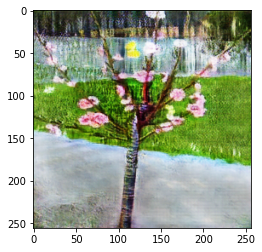

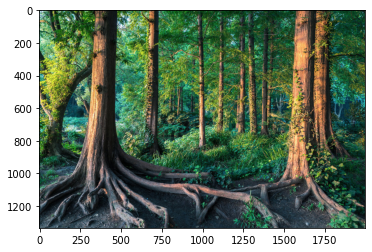

In [21]:
most_similar_image = calc_closest_val(ed, False)

image = plt.imread(os.path.join(vangogh_dir, img))
plt.imshow(image)
plt.show()

image = plt.imread(most_similar_image)
plt.imshow(image)
plt.show()

### Manhattan Distance

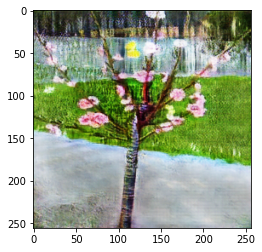

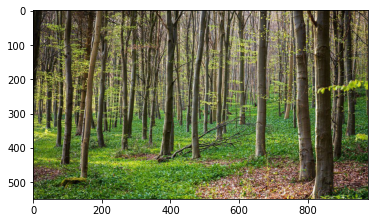

In [22]:
most_similar_image = calc_closest_val(md, False)

image = plt.imread(os.path.join(vangogh_dir, img))
plt.imshow(image)
plt.show()

image = plt.imread(most_similar_image)
plt.imshow(image)
plt.show()

### Vector Cosine Angle Distance

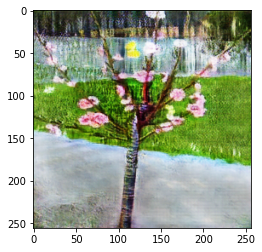

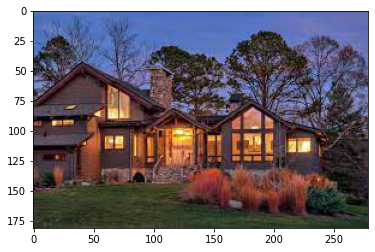

In [24]:
most_similar_image = calc_closest_val(vcad, True)

image = plt.imread(os.path.join(vangogh_dir, img))
plt.imshow(image)
plt.show()

image = plt.imread(most_similar_image)
plt.imshow(image)
plt.show()

## Computation for all images
The results above show that only Euclidean and Manhattan Distance lead to reasonable results. Between the two, Manhattan Distance is the one that still preserves a bit more the color similarity between the two images. Hence, this will be the metric used to pair images together.

N.B.: the execution will take a while, it's normal.

In [38]:
paired_dataset_dir = 'datasets/paired_vangogh_landscape'
if not os.path.exists(paired_dataset_dir):
    os.mkdir(paired_dataset_dir)

content_dir = os.path.join(paired_dataset_dir, 'content')
if not os.path.exists(content_dir):
    os.mkdir(content_dir)

style_dir = os.path.join(paired_dataset_dir, 'style')
if not os.path.exists(style_dir):
    os.mkdir(style_dir)
   
excluded_images = []
for img in os.listdir(vangogh_dir):
    if 'fake' in img:
        # Compute Manhattan distance
        _, md, _ = compute_distances(img, 
                                     vangogh_dir, 
                                     photos_dir, 
                                     compute_eucl=False, 
                                     compute_manhat=True, 
                                     compute_vca=False, 
                                     excluded_imgs=excluded_images)
        
        # Find most similar image's name
        most_similar_image = calc_closest_val(md, False)
        
        # Rename image to pair it with Van Gogh's one and copy both images to their respective folder
        copy2(most_similar_image, content_dir)
        
        prev_name = most_similar_image[most_similar_image.index('trainB'):].replace("trainB/", "")
        extension = most_similar_image[most_similar_image.index('.'):]
        new_name = os.path.join(content_dir, img[:img.index('.')]) + extension
        
        os.rename(os.path.join(content_dir, prev_name), new_name) # keeps file extension
        
        copy2(os.path.join(vangogh_dir, img), style_dir)
        
        excluded_images.append(new_name)

KeyboardInterrupt: 